In [47]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import plot_confusion_matrix

In [2]:
RANDOM_SEED = 42

# 2. Импорт данных

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', df_train.shape)
display(df_train.head())
print('Размерность тестового датасета: ', df_test.shape)
display(df_test.head())

Размерность тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


Размерность тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [8]:
#Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['Train'] = 1 # помечаем где у нас трейн
df_test['Train'] = 0 # помечаем где у нас тест

df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем

# 3. Предварительный анализ данных

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [13]:
(df.isna()).sum()

client_id               0
app_date                0
education               0
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64

In [11]:
# временной ряд (1)
time_cols = ['app_date']
# бинарные переменные (5, без default)
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные переменные (6)
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
# числовые переменные, исключили из списка (5, без client_id)
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income']

In [12]:
df.education.fillna('SCH', inplace = True) # пропуски заполнились значением SCH так как это самый популярный вариант 

IndexError: index 4 is out of bounds for axis 0 with size 4

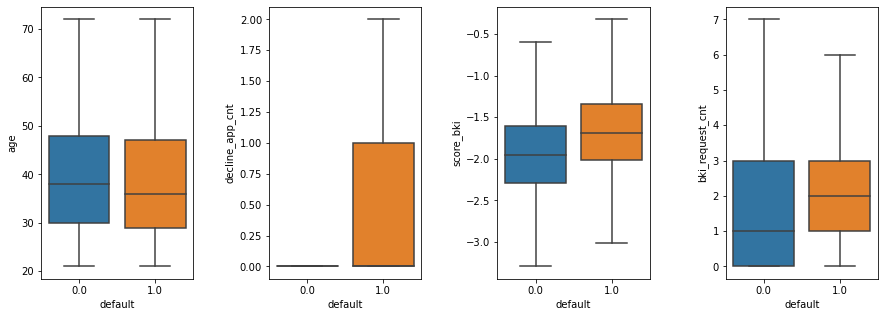

In [14]:
fig, axes = plt.subplots(1, 4, figsize = (15,5))
plt.subplots_adjust(wspace = 0.5)
axes = axes.flatten()

for i in range(len(num_cols)):
    sns.boxplot(x = 'default', y = num_cols[i], data = df, ax = axes[i], orient = 'v', showfliers = False)
    plt.xticks()

<AxesSubplot:>

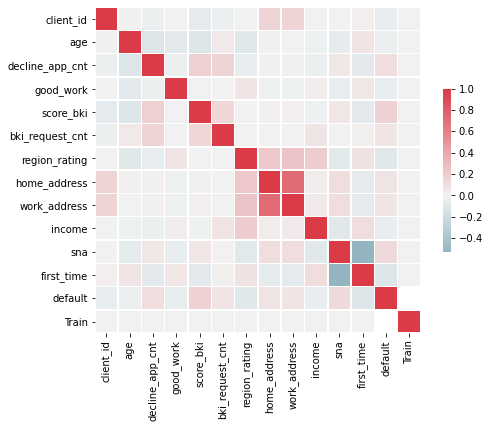

In [15]:
corr = df.corr()
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0., square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:>

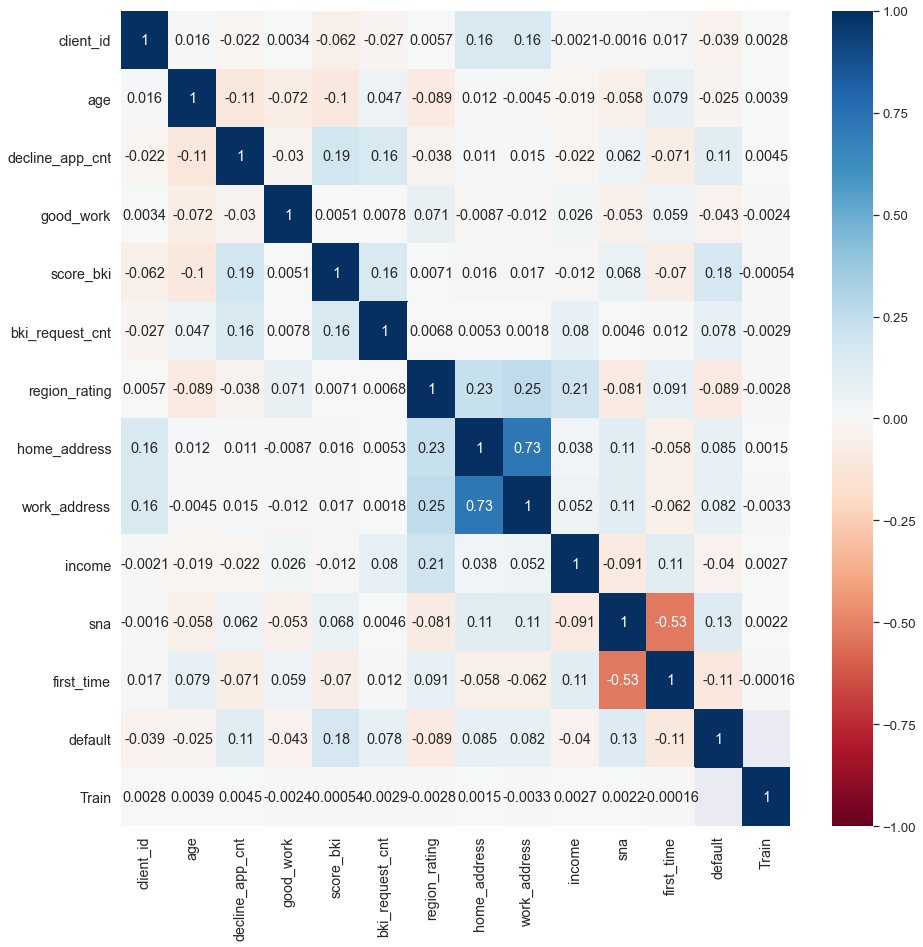

In [17]:
corrMatrix = df.corr()
plt.subplots(figsize=(15, 15))
sns.set(font_scale=1.2)
sns.heatmap(corrMatrix, annot=True, cmap="RdBu", 
           vmin=-1,vmax=1,center=0)

<AxesSubplot:>

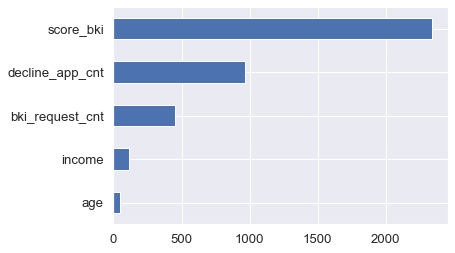

In [20]:
temp_df = df[df['Train']==1]
imp_num = pd.Series(f_classif(temp_df[num_cols], temp_df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

# 3.Подготовка данных к машинному обучению

In [21]:
# Для категориальных признаков мы будем использовать OneHotEncoder
df=pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)

In [22]:
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

In [24]:
df[num_cols] = StandardScaler().fit_transform(df[num_cols].values)

In [26]:
df.drop(['app_date'], axis=1, inplace=True)

<AxesSubplot:>

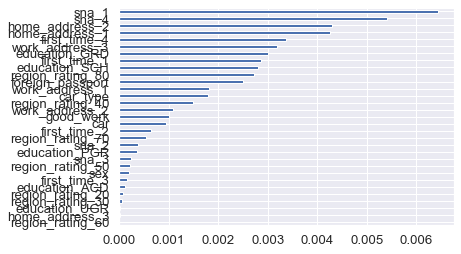

In [29]:
all_cols = list(df.columns)
all_num_cols = num_cols
target_col = ['default']
other_col = ['client_id', 'Train']
all_cat_and_bin_cols = [x for x in all_cols if x not in (all_num_cols+target_col+other_col)]

temp_df = df[df['Train']==1]
imp_cat = pd.Series(mutual_info_classif(temp_df[all_cat_and_bin_cols], temp_df['default'], discrete_features =True), index = all_cat_and_bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

# 4. Построение модели

In [30]:
train_data = df.query('Train == 1').drop(['Train', 'client_id'], axis=1)
test_data = df.query('Train == 0').drop(['Train', 'client_id'], axis=1)

y = train_data.default.values            # наш таргет
X = train_data.drop(['default'], axis=1)

In [31]:
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [32]:

# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((36349, 37), (73799, 37), (73799, 36), (59039, 36), (14760, 36))

In [33]:
# KNeighborsClassifier:
alg_ngbh = KNeighborsClassifier(n_neighbors=3)
alg_ngbh.fit(X_train, y_train)
scores = cross_val_score(alg_ngbh, X_test, y_test, cv=5, scoring='roc_auc', n_jobs=-1)
print("roc_auc (k-neighbors): {}/{}".format(scores.mean(), scores.std()))

roc_auc (k-neighbors): 0.5870536444837349/0.008782794581862586


In [34]:
# GaussianNB:
alg_nbs = GaussianNB()
alg_nbs.fit(X_train, y_train)
scores = cross_val_score(alg_nbs, X_test, y_test, cv=5, scoring='roc_auc', n_jobs=-1)
print("roc_auc (naive bayes): {}/{}".format(scores.mean(), scores.std()))

roc_auc (naive bayes): 0.6885262322070915/0.012282502224516238


In [36]:
# LogisticRegression:
alg_log = LogisticRegression(random_state=RANDOM_SEED, max_iter=200)
alg_log.fit(X_train, y_train)
scores = cross_val_score(alg_log, X_test, y_test, cv=5, scoring='roc_auc', n_jobs=-1)
print("roc_auc (logistic regression): {}/{}".format(scores.mean(), scores.std()))

roc_auc (logistic regression): 0.734903123029589/0.014056414527521504


In [38]:
# RandomForestClassifier:
alg_frst = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=500, min_samples_split=8, min_samples_leaf=2)
alg_frst.fit(X_train, y_train)
scores = cross_val_score(alg_frst, X_test, y_test, cv=5, scoring='roc_auc', n_jobs=-1)
print("roc_auc (random forest): {}/{}".format(scores.mean(), scores.std()))

roc_auc (random forest): 0.7166914801093847/0.007500779273132373


In [39]:
#GradientBoostingClassifier
alg_gb = GradientBoostingClassifier(random_state=RANDOM_SEED)
alg_gb.fit(X_train, y_train)
scores = cross_val_score(alg_gb, X_test, y_test, cv=5, scoring='roc_auc', n_jobs=-1)
print("roc_auc (gradient boosting): {}/{}".format(scores.mean(), scores.std()))

roc_auc (gradient boosting): 0.7355891736331762/0.012963795725745702


In [40]:
alg_xgb = XGBClassifier(random_state=RANDOM_SEED)
alg_xgb.fit(X_train, y_train)
scores = cross_val_score(alg_xgb, X_test, y_test, cv=5, scoring='roc_auc', n_jobs=-1)
print("roc_auc (xg boosting): {}/{}".format(scores.mean(), scores.std()))

C:\Users\gorba\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:27:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
roc_auc (xg boosting): 0.6950159976475422/0.008396266931006972


In [41]:
alg_agb = AdaBoostClassifier(random_state=RANDOM_SEED)
alg_agb.fit(X_train, y_train)
scores = cross_val_score(alg_agb, X_test, y_test, cv=5, scoring='roc_auc', n_jobs=-1)
print("roc_auc (ada boosting): {}/{}".format(scores.mean(), scores.std()))

roc_auc (ada boosting): 0.7327667461533107/0.010848700723934691


In [42]:
alg_lgbm = LGBMClassifier(random_state=RANDOM_SEED)
alg_lgbm.fit(X_train, y_train)
scores = cross_val_score(alg_lgbm, X_test, y_test, cv=5, scoring='roc_auc', n_jobs=-1)
print("roc_auc (lgbm): {}/{}".format(scores.mean(), scores.std()))

roc_auc (lgbm): 0.7217454872412462/0.007560971237809384


# Оценка качества для лучшей модели

In [43]:
#Для градиентного бустинга:
y_pred_prob = alg_gb.predict_proba(X_test)[:,1]
y_pred = alg_gb.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, y_pred))
print('balanced_accuracy_score:', balanced_accuracy_score(y_test, y_pred))
print('precision_score:', precision_score(y_test, y_pred))
print('recall_score:', recall_score(y_test, y_pred))
print('f1_score', f1_score(y_test, y_pred))
print('roc_auc_score', roc_auc_score(y_test, y_pred_prob))

accuracy_score: 0.8759485094850948
balanced_accuracy_score: 0.5073657375507494
precision_score: 0.47058823529411764
recall_score: 0.01751505199781062
f1_score 0.033773087071240104
roc_auc_score 0.739348190503615


# Матрица ошибок

In [45]:
! pip install -q scikit-plot

You should consider upgrading via the 'c:\users\gorba\anaconda3\python.exe -m pip install --upgrade pip' command.


Confusion matrix, without normalization
[[12897    36]
 [ 1795    32]]


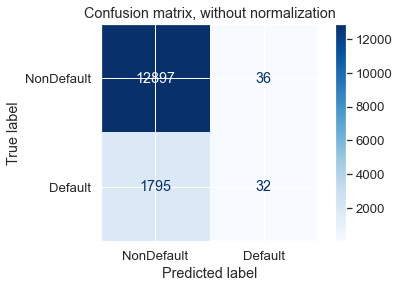

In [49]:
class_names = ['NonDefault', 'Default']

titles_options = [("Confusion matrix, without normalization", None)]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(alg_gb, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

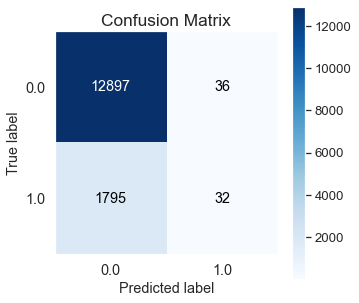

In [50]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    y_pred,
    figsize=(5,5));

C:\Users\gorba\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


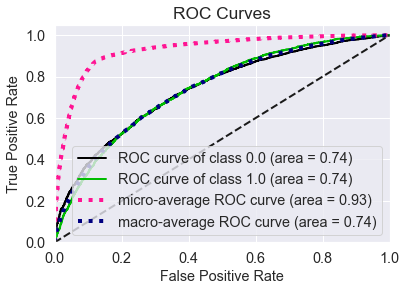

In [51]:
y_probas = alg_gb.predict_proba(X_test)

skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.show()

C:\Users\gorba\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


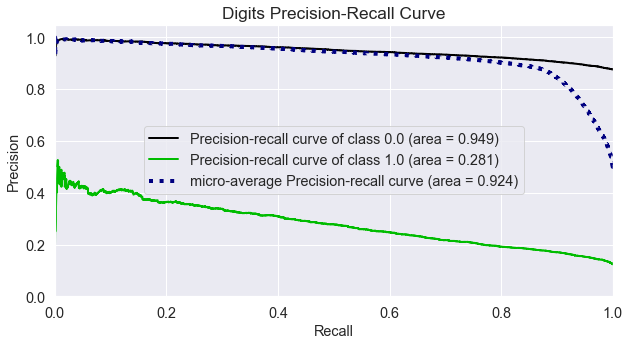

In [53]:
skplt.metrics.plot_precision_recall_curve(y_test, y_probas, title="Digits Precision-Recall Curve", figsize=(10,5));

# Итог

In [78]:
train_data = df.query('Train == 1').drop(['Train', 'client_id'], axis=1)
test_data = df.query('Train == 0').drop(['Train', 'client_id'], axis=1)

In [79]:
X_train=train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

In [80]:
test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 37), (73799, 37), (73799, 36), (73799,), (36349, 36))

In [81]:
model = GradientBoostingClassifier(random_state=RANDOM_SEED)
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:,1]

In [82]:
len(y_pred_prob), len(X_test)

(36349, 36349)

In [83]:
submit = pd.DataFrame(df_test.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)